# ENERGY DEMAND FORECASTING
**Authors: Cayt Schlichting, Arsène Boundaoné, Lochlyn Laskowski, Greg Maggard**<br>
*Audience: Data Science Teams for Energy Grid Operators*

**Project Goal:** Produce a time-series model that forecasts three days of energy demand in ERCOT's coastal region. Deploying this model will allow ERCOT to anticipate demand effectively in order to schedule energy generation and inform bidding prices.



**Jump to Section:** &ensp;   [Acquisition and Prep](#acq-prep) - [Exploration](#explore) - [Modeling](#modeling) - [Conclusion](#ConclusionC88)

In [1]:
#Basics
import numpy as np
import pandas as pd
from math import sqrt
import itertools
from IPython.display import Markdown, display

#Ignore warnings and info
import logging
logging.disable(logging.INFO)
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

#Viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind') #set theme for all viz
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
#pio.templates.default = "plotly_dark"
plt.rcParams["figure.figsize"] = (18,12)
plt.style.use('seaborn-colorblind')

#modeling, stats and time series
import scipy.stats as stats
alpha = .05
import datetime as dt
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from sktime.forecasting.model_selection import SlidingWindowSplitter

from pandas.tseries.holiday import USFederalHolidayCalendar
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

#Modules
import wrangle as wr

***
## Data Acquisition and Preparation  <a class="anchor" id="acq-prep">
***

**Source:** 
>    - ERCOT for energy demand data.
>    - Virtual Crossing for weather data.

**Filtering:**
> - Limited weather data to include 1/1/2010 to 6/30/22 to align with ERCOT load data.
> - Limited data to only include ERCOT's coastal region.

**Cleaning:**
> - ERCOT Data:
    - Clean up DateTime values, converting "24:00:00" values to midnight the next day.
    - Localizing DateTime values to US/Central Standard Time
    - Creating columns to highlight whether a given date is a weekday, observed holiday, and list the day of week.
> - Weather Data:
    - Shifted dates affected by Daylight Savings, so that there are no duplicates and the dates are continuous
> - Combined Data:
    - Combined the weather and ERCOT DataFrames on their newly-cleaned DateTime columns. Default output is to keep Central Standard Time, but can also be output to UTC.

##### Acquire, Prep and Split data

In [2]:
#Using a function to pull the combined weather and energy demand data:
df = wr.get_combined_df()

**Mean Temperature:** 

A simple mean temperature column was created by using data from all four cities.  While the Coastal region is relatively small, we wanted to capture the temperature variations in some way.  We suspect that either this column, or the Houston temperature column will have the strongest relationship with ERCOT load for this region.  The reason we suspect Houston to perform better than the other cities is that it contains the vast majority of the population for this region - which is a known driver of energy demand.

In [3]:
#add in mean_temp
df['mean_temp'] = (df.hs_temp + df.gv_temp + df.pl_temp + df.vc_temp)/4

**Train/Test Split:** 

The Train set consists of data containing years 2010 through 2017, totaling 8 years. We used the first 4 years of the Train set to train the model, and then the next 4 years to cross-validate the data via sliding 36-day cross-validation windows.  

The Test set contains dates from the beginning of 2018 through June 2022, totaling 4.5 years. We ran our model with a tightened forecast window of 6 days, as opposed to the 36 used on the latter half of the Train set.

In [4]:
#Splitting Data in to Train and Test sets by year:
train = df[:'2017']
test = df['2018':]

***
## Exploration  <a class="anchor" id="explore" />
***
*More exploration can be found in the supporting notebooks*


##### Distribution of Mean ERCOT Load Over Time

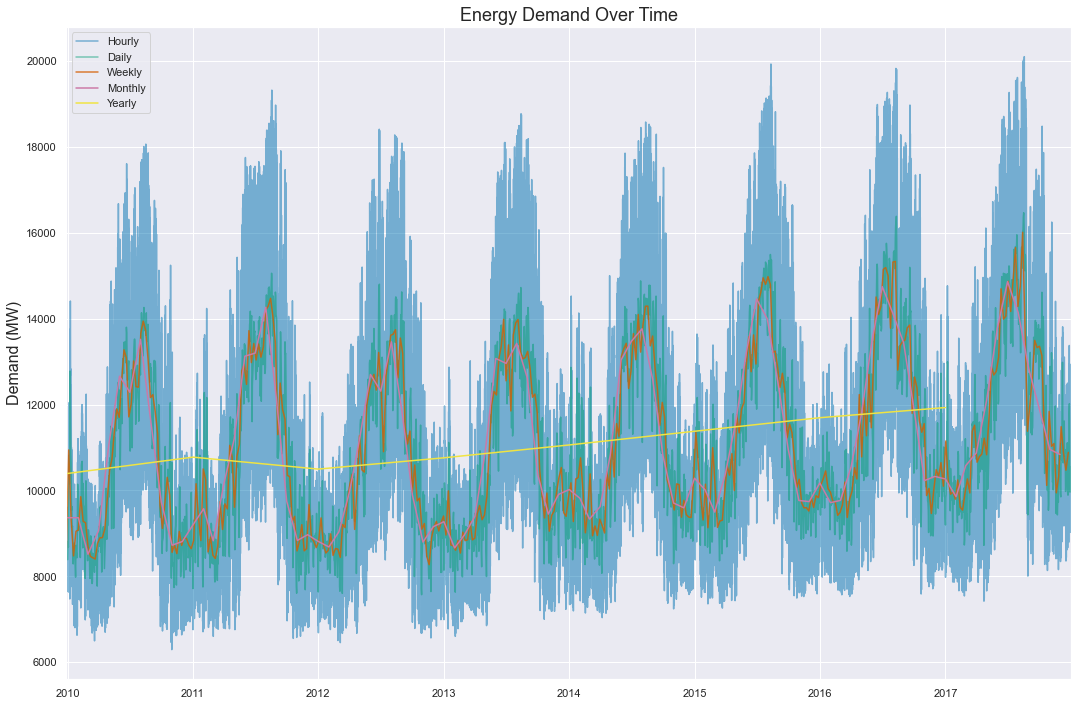

In [5]:
train.resample('H').ercot_load.mean().plot(alpha=.5, label='Hourly')
train.resample('D').ercot_load.mean().plot(alpha=.5, label='Daily')
train.resample('W').ercot_load.mean().plot(alpha=.8, label='Weekly')
train.resample('M').ercot_load.mean().plot(label='Monthly')
train.resample('Y').ercot_load.mean().plot(label='Yearly')
plt.xlabel('')
plt.ylabel('Demand (MW)', fontsize = 16)
plt.title('Energy Demand Over Time', fontsize = 18)
plt.legend();

### What do Coastal Zone Temperatures Look Like Over Time?

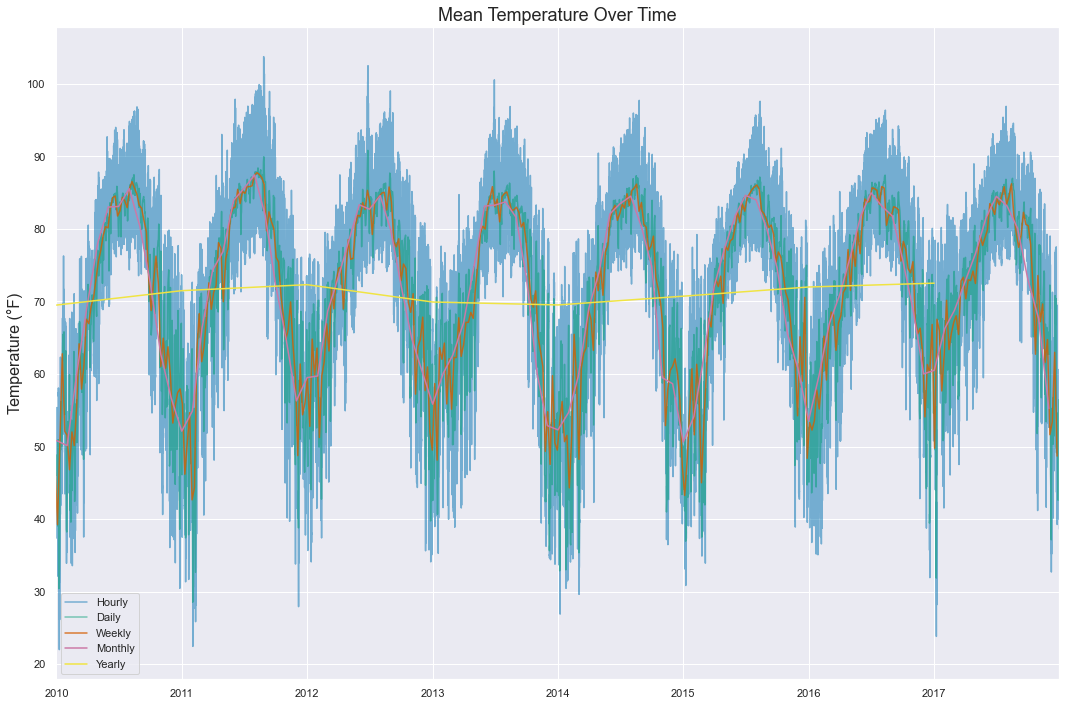

In [6]:
train.resample('H').mean_temp.mean().plot(alpha=.5, label='Hourly')
train.resample('D').mean_temp.mean().plot(alpha=.5, label='Daily')
train.resample('W').mean_temp.mean().plot(alpha=.8, label='Weekly')
train.resample('M').mean_temp.mean().plot(label='Monthly')
train.resample('Y').mean_temp.mean().plot(label='Yearly')
plt.title('Mean Temperature Over Time', fontsize = 18)
plt.xlabel('')
plt.ylabel('Temperature (°F)', fontsize = 16)
plt.legend();

### Energy Use by Weekday

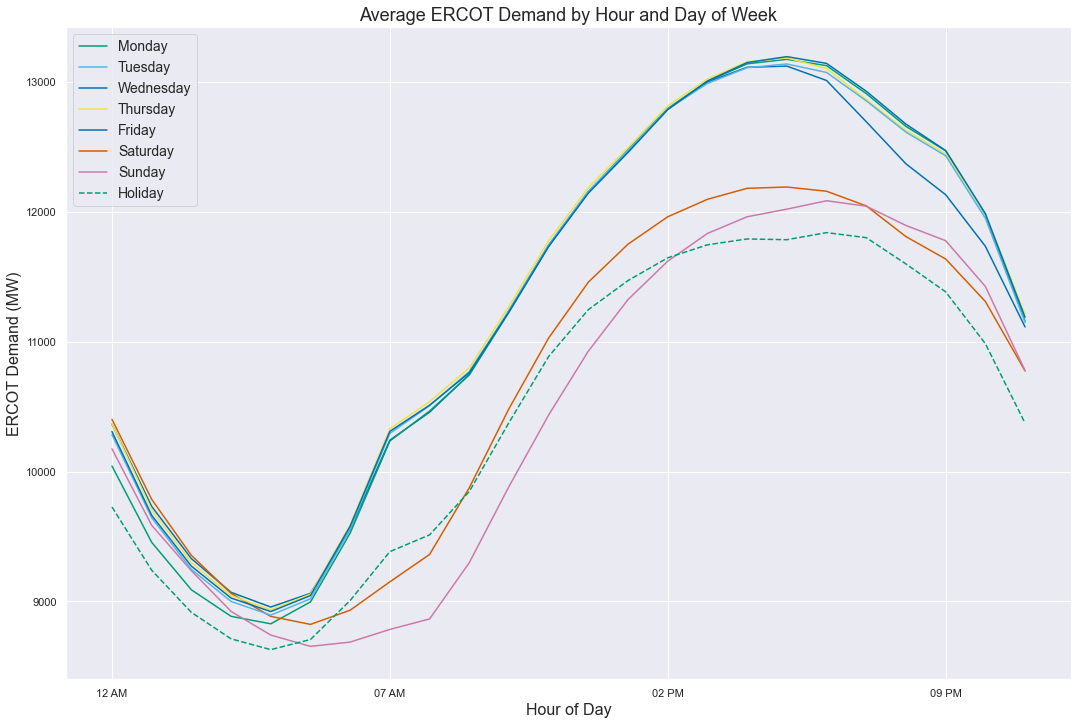

In [7]:
wr.plot_weekday_energy(train);

<div class='alert alert-success'><b>Notes:</b> Overall, energy demand is lowest in the early morning hours and begins to increase until it peaks around 1700 and then gradually decreases to back to its lowest point. Energy demand is similar across the weekdays with a sharp increase in demand around 0500. The weekends utilize less energy in the early morning and increase demand later in the day, around 0800.  Both weekend days and observied holidays have much lower peak energy demand than weekdays.</div>

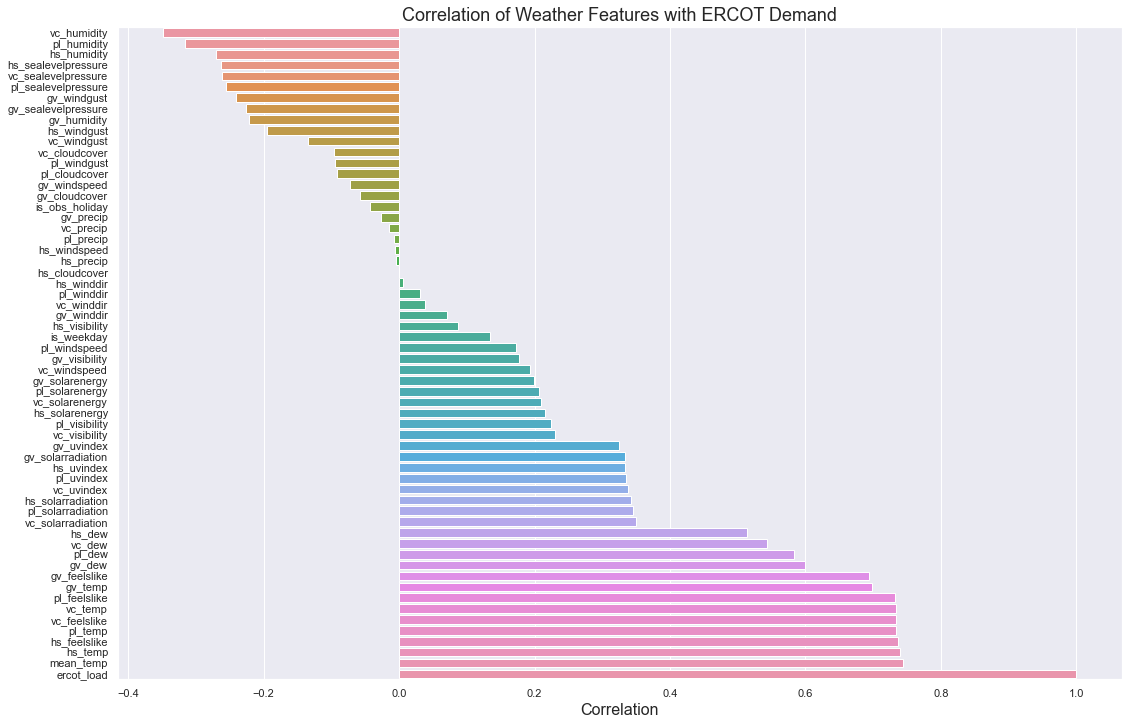

In [8]:
correlation = pd.DataFrame()
correlation['columns'] = train.corrwith(train['ercot_load'],method='spearman').index
correlation['correlation'] = train.corrwith(train['ercot_load'],method='spearman').values
sns.barplot(data=correlation.sort_values('correlation'), x='correlation', y='columns')
plt.title('Correlation of Weather Features with ERCOT Demand',fontsize=18)
plt.ylabel(None)
plt.xlabel("Correlation",fontsize=16)
plt.show()

<div class='alert alert-success'><b>Notes:</b>
<ul>
    <li>The strongest <b>positive</b> correlation between ercot load occurs with mean_temp. <b>(approximately .74)</b></li>
    <li>The strongest <b>negative</b> correlation between ercot load occurs with vc_humidity and pl_humidity. <b>(approximately <sup>-</sup>.32)</b></li>
    </ul></div>

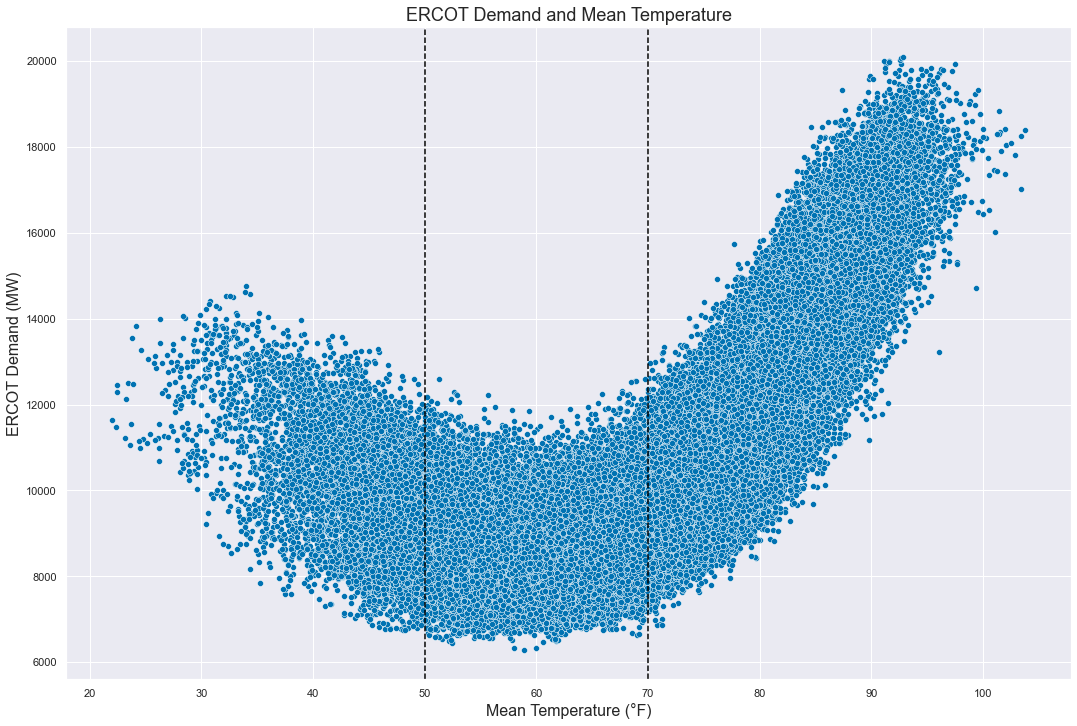

In [9]:
wr.plot_temp_ercot(train);

<div class='alert alert-success'>
    <b>Notes:</b>We can visually see the relationship between temperature like and ERCOT load, depicted by the U shape. To further test this relationship we performed hypothesis testing. Since Spearman's correlation assumes monotonic relationships, we divided the temperatures into three different ranges.
    <ul>
        <li>Less than 50 degrees</li>
        <li>Between 50 and 70 degrees</li>
        <li>Greater than 70 degrees</li>
    </ul>
</div>

**Hypothesis Testing:**

- **Null Hypothesis:** There is no relationship between ercot load and mean temperature.
- **Alternative Hypothesis:** There is a relationship between ercot load and mean temperature.

In [10]:
# Temperatures greater than 70 degrees:
less_50, mid_temp, greater_70 = wr.temp_subgroups(train)
r, p = stats.spearmanr(greater_70.ercot_load, greater_70.mean_temp)
r, p

(0.8273769795806295, 0.0)

In [11]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [12]:
#Temperatures between 50 and 70 degrees:
r, p = stats.spearmanr(mid_temp.ercot_load, mid_temp.mean_temp)
r, p

(0.07269098804166944, 1.0057663190117336e-27)

In [13]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


In [14]:
r, p = stats.spearmanr(less_50.ercot_load, less_50.mean_temp)
r, p

(-0.4378800064485227, 2.2237765416637823e-287)

In [15]:
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis.


<div class="alert alert-success"><b>Notes: </b>The strongest relationship between temperature and ERCOT load is when it is greater than 70 degrees with a correlation coefficient of .83. There is a moderate negative relationship between temperatures that are less than 50 degress with a correlation coefficient of -.44. While, the mid-range temperatures are not as strongly correlated, all three ranges of temperatures are related to ERCOT load in regards to statistical significance.
</div>

### Exploration Summary:

**Key Findings:**
> - Mean energy demand increased over time.
> - Mean temperature stayed relatively consistent over this 8 year window.
> - Energy use is higher on weekdays than on weekends.
> - Holidays use less demand than non-holidays
> - Holidays were most similar to weekend days, but tended to show lower demand in evening hours.
> - Strongest positive correlation with ERCOT load occurred with mean temperature and mean feelslike (.74)
> - Strongest negative correlatin with ERCOT load occurred with mean humidity (-.32).
> - Temperature has a strong correlation with ERCOT energy demand when the temperature is above 70 degrees and a moderate correlation when the temperature is below 50 degrees.  
> - Energy demand is lowest at approximately 0400 and begins to increase shortly after. Energy demand peaks at around 1700, and then gradually declines back to the lowest point. 


***
## Modeling <a class="anchor" id="modeling" />
***
*More modeling can be found in the supporting notebooks*
    
<div class="alert alert-info"><b>MODEL EVALUATION:  These models will be evalutated using root-mean-square errorr (RMSE) and mean absolute percentage error (MAPE) on a 1 day and 3 day basis.</b>
    <ul>
        <li><b>RMSE</b> allows us to see the overall error of the model in the energy load units (MW).</li>
        <li><b>MAPE</b> complements that by telling us how accurate the model is on a percentage basis.  This is important as the energy load varies greatly throughout the year, so a 1000 MW RMSE on a hot summer day will have a much lower MAPE percentage than a 1000 MW RMSE on a comfortable Saturday in the Fall.</li>
        <li>The <b>3 day metrics</b> will tell us the overall performance of the 3 day forecast.  However, we expect the 3rd day to be less accurate than the 1st day and production models will be re-run on a daily or sub-daily basis. For that reason, we also will look at <b>1 day metrics</b> to see the model performance over the first day only.</li>
    </ul></div>
    

<div class="alert alert-info"><b>CROSS-VALIDATION:</b><br><br>Cross validation was performed on a sliding window.  Models were trained on <b>4 year initial windows</b>, with a <b>forecasting horizon of 3 days</b>.  Due to the large amount of data we had available, we minimized processing time by using a <b>36 day sliding offset</b>.  A 36 day offset ensured that our forecasting window started at different days of the week and rotated through different parts of the month. <br><br> The downside to this approach is that it is possible the model is not tested over more anomalous time periods (such as holidays or major weather events like Hurrican Harvey).  A smaller sliding offset (such as 1 or 2 days) would catch those time periods, however it would require much more processing time. </div>

##### Set up Sliding Window Splitter

In [16]:
# Setup for the implementation of the SlidingWindowSplitter
window_length = 1461*24   #4 years in hour increments
fh = 24*3                 #3 days in hour increments
step_length=36*24         #36 days in hour increments

In [17]:
#Create Splitter object
sws = SlidingWindowSplitter(window_length=window_length, fh=fh, step_length=step_length)

### Baseline Model

<div class='alert alert-success'>For baseline, we chose to use the average ERCOT demand of the past 7 days.  This allowed us to capture both daily and weekly variability to make a more accurate baseline prediction</div>

In [18]:
#Resample by hour
main_train = train.resample('H').ercot_load.mean().to_frame()

In [19]:
# Initialize performance dataframe
performance_df_1d = pd.DataFrame(columns=['rmse', 'mape'])
performance_df_3d = pd.DataFrame(columns=['rmse', 'mape'])

#Create cross-validation splits and run baseline on each
for i, (train_index, val_index) in enumerate (sws.split(main_train)):
    # Storing windows in our window function
    train_df = main_train.iloc[train_index]
    val_df = main_train.iloc[train_index[-1]+1:val_index[0]+1]
    
    # Creating a baseline as the last week of each train window
    baseline = train_df.iloc[-168:].ercot_load.mean()
    #Store as predicted values
    val_df['yhat'] = baseline

    #Get model performance
    rmse1 = sqrt(mean_squared_error(val_df.ercot_load[:24], val_df.yhat[:24]))
    mape1 = wr.mean_absolute_percentage_error(val_df.ercot_load[:24], val_df.yhat[:24])
    rmse3 = sqrt(mean_squared_error(val_df.ercot_load, val_df.yhat))
    mape3 = wr.mean_absolute_percentage_error(val_df.ercot_load, val_df.yhat)

    #store baseline performance in df
    perf1 = {'rmse' : rmse1, 'mape':mape1}
    perf3 = {'rmse' : rmse3, 'mape':mape3}     
    performance_df_1d = performance_df_1d.append(perf1,ignore_index=True)
    performance_df_3d = performance_df_3d.append(perf3,ignore_index=True)

In [20]:
#Get mean rmse and mape for 1 and 3 day, pretty print
wr.print_model_results('Baseline',performance_df_1d.mean().to_frame().T,performance_df_3d.mean().to_frame().T)


Baseline model performance:
1 day rmse: 1775.0 MW
1 day mape: 13.14%
3 day rmse: 1896.0 MW
3 day mape: 13.87%


### Holts-Winters Exponential Smoothing

<div class='alert alert-success'>This model does standard time series forecasting with a trend and seasonal component.  The hyperparameters we chose for this model are:
<ul>
    <li>Additive trend</li>
    <li>Additive seasonality</li>
    <li>Seasonal period of 1 day</li>
    </ul>
    </div>

In [21]:
# Holt-Winters fitting and prediction
hwes_perf_df_1d = pd.DataFrame(columns=['rmse', 'mape'])
hwes_perf_df_3d = pd.DataFrame(columns=['rmse', 'mape'])

for i, (train_index, val_index) in (enumerate (sws.split(main_train))):
    # Storing windows in DataFrames for train and validate
    hwes_train_df = main_train.iloc[train_index]
    hwes_val_df = main_train.iloc[train_index[-1]+1:val_index[0]+1]
    
    # Creating a model as the last week of each train window
    model = ExponentialSmoothing(endog = hwes_train_df.ercot_load, 
                                 trend ='add', 
                                 seasonal = 'add', 
                                 seasonal_periods = 24).fit() #optimized = False
    #get model predictions
    pred = model.predict(start=hwes_val_df.index[0], end=hwes_val_df.index[-1])
    predictions = pred.to_frame(name='ercot_load')

    #Get model performance
    rmse1 = sqrt(mean_squared_error(hwes_val_df.ercot_load[:24], predictions.ercot_load[:24]))
    mape1 = wr.mean_absolute_percentage_error(hwes_val_df.ercot_load[:24], predictions.ercot_load[:24])
    rmse3 = sqrt(mean_squared_error(hwes_val_df.ercot_load, predictions.ercot_load))
    mape3 = wr.mean_absolute_percentage_error(hwes_val_df.ercot_load, predictions.ercot_load)

    #store baseline performance in df
    perf1 = {'rmse' : rmse1, 'mape':mape1}
    perf3 = {'rmse' : rmse3, 'mape':mape3}     
    hwes_perf_df_1d = hwes_perf_df_1d.append(perf1,ignore_index=True)
    hwes_perf_df_3d = hwes_perf_df_3d.append(perf3,ignore_index=True)

In [22]:
#Get mean rmse and mape for 1 and 3 day, pretty print
wr.print_model_results('Holts-Winters Exponential Smoothing',hwes_perf_df_1d.mean().to_frame().T,hwes_perf_df_3d.mean().to_frame().T)

Holts-Winters Exponential Smoothing model performance:
1 day rmse: 1025.0 MW
1 day mape: 7.48%
3 day rmse: 1431.0 MW
3 day mape: 10.42%


<div class='alert alert-success'><b>Notes:</b> This model performed notably better than baseline with a 3 day MAPE of 10.4% compared to the 13.9% by baseline.  The 1 day forecast was even more accurate with a MAPE of 7.5%, compared to 13.1% for baseline.</div>

### Prophet Models

**Note:** You will notice that we re-acquire the dataframes in this section.  Prophet requires time zone naive inputs, however we wanted our explore section above to display CST time zones for readability.

In [23]:
#Acquire data
dfr = wr.get_prophet_df_w_meantemp()
#Filter train based on CST time (EOY 2017, time zone naive UTC time is in this df)
trainr = dfr[dfr.ds < '2018-01-01 06:00:00']
testr = dfr[dfr.ds > '2014-01-01 04:00:00']

#Create df w/o regression column
train = trainr[['ds','y']].copy()

In [24]:
#Set metrics to evaluate
metrics = ['rmse','mape']

##### Basic Prophet model
<div class='alert alert-success'>Uses default Prophet settings:
<ul>
    <li>Auto for all seasonality</li>
    <li>No holidays</li>
    <li>No regression</li>
    </ul>
    </div>

In [25]:
#Create and Fit Basic Prophet model
model = Prophet().fit(train)

#Create cross-validation matrix
df_cv = cross_validation(model,initial='1461 days', period='36 days', horizon = '3 days')

#Get 1 and 3 day model performance
df_p_1d = performance_metrics(df_cv,rolling_window=.33,metrics=metrics)
df_p_3d = performance_metrics(df_cv,rolling_window=1,metrics=metrics)

  0%|          | 0/41 [00:00<?, ?it/s]

In [26]:
#print model results
wr.print_model_results('Basic Prophet',df_p_1d,df_p_3d)

Basic Prophet model performance:
1 day rmse: 1220.0 MW
1 day mape: 8.1%
3 day rmse: 1302.0 MW
3 day mape: 8.53%


<br>
<b>View Settings for Automatic Seasonality</b>

In [27]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('daily',
              {'period': 1,
               'fourier_order': 4,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

<div class='alert alert-success'><b>Seasonality Notes:</b>
<ul>
    <li>The auto seasonality set a scale of 10 for the yearly, weekly and daily seasons.  Based off our industry knowledge and exploration of the data, we expect the daily and weekly seasonalities to carry a higher weight than the yearly seasonality.  In addition, we are concerned that yearly seasonality is a proxy for a temperature regressor and that including both may be detrimental to the model.</li>
    <li>The yearly fourier order of 10 seemed quite high compared to the weekly order of 3 and daily order of 4.</li>
    <li>We want all seasonalities to be additive.</li>
    </ul>
</div>

##### Prophet Model v2 - Hyperparameter first pass 

<div class='alert alert-success'><b>Hyperparameter settings:</b>
<ul>
    <li>Remove auto-seasonality</li>
    <li>Manually add seasonality:
    <ul>
        <li>daily fourier order of 6, with a scale of 30</li>
        <li>weekly fourier order of 6, with a scale of 30</li>
        <li>yearly fourier order of 6, with a scale of 10</li>
        <li><b>note</b>: We choose a higher daily and weekly order and scale, while lowering yearly scale.
        </ul>
    </li>
    <li>Added US Federal observed holidays</li>
    <li>Added mean temperature regressor</li>
    </ul>
    </div>

In [28]:
#Get US holidays
only_holidays = wr.get_holiday_df(trainr)

In [29]:
#Create and fit model
#Create model
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            holidays=only_holidays)
#Add Seasonality
m = m.add_seasonality(name='daily', 
                      period=1, 
                      fourier_order=6,
                      prior_scale=30
                     )

m = m.add_seasonality(name='weekly', 
                      period=7, 
                      fourier_order=6,
                      prior_scale=30
                     )
m = m.add_seasonality(name='yearly', 
                      period=365.25, 
                      fourier_order=6,
                      prior_scale=10
                     )
#Add Regressor
m = m.add_regressor('mean_temp')

#fit model
m.fit(trainr)

#Perform cross-validation
df_cv_v2 = cross_validation(m, initial='1461 days', period='36 days', horizon = '3 days') 
#Get performance metrics
df_v2_1d = performance_metrics(df_cv_v2, rolling_window=.33, metrics=metrics)
df_v2_3d = performance_metrics(df_cv_v2, rolling_window=1, metrics=metrics)

#print model results
wr.print_model_results('Prophet - First Hyperparameter Pass',df_v2_1d,df_v2_3d)

  0%|          | 0/41 [00:00<?, ?it/s]

Prophet - First Hyperparameter Pass model performance:
1 day rmse: 1191.0 MW
1 day mape: 7.98%
3 day rmse: 1279.0 MW
3 day mape: 8.41%


##### Prophet post-Hyperparameter tuning

**Note:** While we would have preferred to run more hyperparameter combinations all at once, we were limited by the processing time.  We chose to do smaller batches of hyperparameters so that we could perform more iterations while still maximizing the combinations.

<div class='alert alert-info'><b>Hyperparameter Tuning - Round 1 - 48 models</b>
<br><br><u>Hyperparameters:</u>
    <ul>
        <li>Remove yearly seasonality as it is a proxy for the temperature regressor. We suspect the two are not independent.</li>
        <li>Keep the mean temperature as a regressor.</li>
        <li>Try multiple scales [10,20,30] and fourier orders [2,3] for daily and weekly seasonalities</li>
        </ul>

<b>Results:</b> 
<ul>
    <li>This performed significantly worse than the first pass, with the highest performing model having a 3 day MAPE of 13.2%. <b>Action:</b> Re-add in the yearly seasonality</li>
    <li>Seasonal scales of 10 across the board performed the best - which may be due to using the default holiday and regressor scale.  <b>Action:</b> Go with lower seasonal scales. </li>
    <li>The top performing models all had daily and weekly fourier orders of 3. <b>Action:</b> Try fourier orders of 3+.</li>
    </ul>
</div>

<div class='alert alert-info'><b>Hyperparameter Tuning - Round 2 - 36 models</b>
<br><br><u>Hyperparameters:</u>
    <ul>
        <li>Added yearly seasonality with scale of 5 and 10</li>
        <li>Use a daily and weekly scale of 10</li>
        <li>Use daily and yearly fourier orders of 3-5, and a weekly fourier order of 3 and 4.</li>
        </ul>

<b>Results:</b> 
<ul>
    <li>Significant improvement in 3 day MAPE from the first round of models, with the best at 8.2%. <b>Action:</b> Keep yearly seasonality</li>
    <li>Top models contained a daily fourier order of 5. <b>Action:</b> Try 5+ in next round. </li>
    <li>Top models contained a yearly fourier order of 3. <b>Action:</b> Try 2 and 3 in next round. </li>
    <li>Mixed results on yearly scale options of 5 and 10 and weekly order of 3 and 4. Slight edge for a scale of 5 and order of 3.</li>
    </ul>
</div>

<div class='alert alert-info'><b>Hyperparameter Tuning - Round 3 - 12 models</b>
<br><br><u>Hyperparameters:</u>
    <ul>
        <li>Keep daily, weekly, yearly scales of 10, 10 and 5, respectively.  Try regressor scales of 10 and 15.</li>
        <li>Use a daily fourier order of 5-7</li>
        <li>Use yearly fourier order of 2 and 3.</li>
        </ul>

<b>Results:</b> 
<ul>
    <li>Yearly fourier order of 3 consistently outperformed. <b>Action:</b> Keep yearly at 3.</li>
    <li>Regressor scales of 10 mostly outperformed scales of 15. <b>Action:</b> Keep regressor scale of 10. </li>
    <li>Mixed results on daily fourier order, however 5 performed best in situations with the last two bullets. <b>Action:</b> Keep daily order of 5</li>
    </ul>
</div>

<div class='alert alert-info'><b>Hyperparameter Tuning - Round 4 - 24 models</b>
<br><br><u>Hyperparameters:</u>
    <ul>
        <li>Try smaller scale changes of 8 and 10 for daily, 8, 10 and 12 for weekly and 5 and 7 for yearly. Keep regressor at 10.</li>
        <li>Use a daily fourier order of 5 and a yearly fourier order of 3</li>
        <li>Use weekly fourier order of 3 and 5.</li>
        </ul>

<b>Results:</b> 
<ul>
    <li>Weekly fourier order of 5 consistently outperformed. <b>Action:</b> Potentially try 5+.</li>
    <li>Yearly scale of 7 consistently outperformed <b>Action:</b> Keep yearly scale of 7, consider trying 10 again on final round since it performed very closesly to 5 in the past. </li>
    <li>Given the above bullets, daily and weekly scales of 10 performed best. <b>Action:</b> Keep at 10</li>
    </ul>
</div>

<div class='alert alert-info'><b>Hyperparameter Tuning - Round 5 (Final) - 12 models</b>
<br><br><u>Hyperparameters:</u>
    <ul>
        <li>Daily, weekly and regressor scales at 10. Yearly scales at 7 and 10.</li>
        <li>Daily fourier order of 5, yearly fourier order of 3.  Weekly fourier order of 5-10.</li>
        <li>US Federal Observed holidays</li>
        <li>Mean Temperature regressor</li>
        </ul>

<b>Results:</b> 
<ul>
    <li>A weekly fourier order of of 9 outperformed all other options</li>
    <li>A yearly scale of 10 outperformed the scale of 7.</li>
    </ul>
</div>

##### Top Performing Prophet Model

<div class='alert alert-success'>
<b>Hyperparameters:</b>
    <ul>
        <li>Daily, weekly, yearly and regressor scales at 10.</li>
        <li>Daily fourier order of 5, weekly fourier order of 9, and a yearly fourier order of 3.</li>
        <li>US Federal Observed holidays</li>
        <li>Mean Temperature regressor</li>
        </ul>
</div>

In [30]:
#Create the model
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            holidays=only_holidays)
#Add seasonalities
m = m.add_seasonality(name='daily', 
                      period=1, 
                      fourier_order=5,
                      prior_scale=10
                     )
m = m.add_seasonality(name='weekly', 
                      period=7, 
                      fourier_order=9,
                      prior_scale=10
                     )
m = m.add_seasonality(name='yearly', 
                      period=365.25, 
                      fourier_order=3,
                      prior_scale=10
                     )
#Add Regressors
m = m.add_regressor('mean_temp')

#fit model
m.fit(trainr)

#Perform cross-validation
df_cv_final = cross_validation(m, initial='1461 days', period='36 days', horizon = '3 days') 
#Get performance metrics
df_final_1d = performance_metrics(df_cv_final, rolling_window=.33, metrics=metrics)
df_final_3d = performance_metrics(df_cv_final, rolling_window=1, metrics=metrics)

  0%|          | 0/41 [00:00<?, ?it/s]

In [31]:
#print model results
wr.print_model_results('Tuned Prophet Model',df_final_1d,df_final_3d)

Tuned Prophet Model model performance:
1 day rmse: 1188.0 MW
1 day mape: 7.91%
3 day rmse: 1230.0 MW
3 day mape: 8.15%


### Run Model on Test Dataset

In testing our model's performance, we again used cross-validation techniques to get model performance over multiple 3 day forecast windows.  To greater test the model in this dataset, we shortened the sliding window to create a forecast every 6 days over this time period (January 2018 - June 2022).

##### Re-Create splitter for 6 day rolling window

In [32]:
#Create Splitter object
step_length_test = 6*24 #6 days in 24 hour increments
sws_test = SlidingWindowSplitter(window_length=window_length, fh=fh, step_length=step_length_test)

##### Create Test Baseline

In [33]:
# Initialize performance dataframe
baseline_test_df_1d = pd.DataFrame(columns=['rmse', 'mape'])
baseline_test_df_3d = pd.DataFrame(columns=['rmse', 'mape'])

#Create cross-validation splits and run baseline on each
for i, (train_index, val_index) in enumerate (sws_test.split(testr)):
    # Storing windows in our window function
    train_df = testr.iloc[train_index]
    val_df = testr.iloc[train_index[-1]+1:val_index[0]+1]
    
    # Creating a baseline as the last week of each train window
    baseline = train_df.iloc[-168:].y.mean()
    #Store as predicted values
    val_df['yhat'] = baseline

    #Get model performance
    rmse1 = sqrt(mean_squared_error(val_df.y[:24], val_df.yhat[:24]))
    mape1 = wr.mean_absolute_percentage_error(val_df.y[:24], val_df.yhat[:24])
    rmse3 = sqrt(mean_squared_error(val_df.y, val_df.yhat))
    mape3 = wr.mean_absolute_percentage_error(val_df.y, val_df.yhat)

    #store baseline performance in df
    perf1 = {'rmse' : rmse1, 'mape':mape1}
    perf3 = {'rmse' : rmse3, 'mape':mape3}     
    baseline_test_df_1d = baseline_test_df_1d.append(perf1,ignore_index=True)
    baseline_test_df_3d = baseline_test_df_3d.append(perf3,ignore_index=True)
    

In [34]:
#Print model results
wr.print_model_results('Test Baseline',baseline_test_df_1d,baseline_test_df_3d)

Test Baseline model performance:
1 day rmse: 1685.0 MW
1 day mape: 11.89%
3 day rmse: 2889.0 MW
3 day mape: 18.75%


##### Re-fit Top Performing Model on Test

In [35]:
#Re-Create the Top Prophet Model
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            holidays=only_holidays)
#Add seasonalities
m = m.add_seasonality(name='daily', 
                      period=1, 
                      fourier_order=5,
                      prior_scale=10
                     )
m = m.add_seasonality(name='weekly', 
                      period=7, 
                      fourier_order=9,
                      prior_scale=10
                     )
m = m.add_seasonality(name='yearly', 
                      period=365.25, 
                      fourier_order=3,
                      prior_scale=10
                     )
#Add Regressors
m = m.add_regressor('mean_temp')
#refit same model as above
m.fit(testr)
#Perform cross-validation
df_cv_test = cross_validation(m, initial='1461 days', period='6 days', horizon = '3 days') 
#Get performance metrics
df_test_1d = performance_metrics(df_cv_test, rolling_window=.33, metrics=metrics)
df_test_3d = performance_metrics(df_cv_test, rolling_window=1, metrics=metrics)

  0%|          | 0/274 [00:00<?, ?it/s]

In [36]:
#print model results
wr.print_model_results('Tuned Prophet',df_test_1d,df_test_3d)

Tuned Prophet model performance:
1 day rmse: 1419.0 MW
1 day mape: 8.88%
3 day rmse: 1374.0 MW
3 day mape: 8.52%


In [37]:
sws_test.get_n_splits(testr)

274

### Modeling Summary:


##### Model Performance on Train Split

*Baseline:*

|         |**MAPE**|**RMSE**|
|---------|--------|--------|
|**1 Day**|13.14%|1775 MW|
|**3 Day**|13.87%|1896 MW|

<br><br><br><br><br>
*Holts Winters:*

|         |**MAPE**|**RMSE**|
|---------|--------|--------|
|**1 Day**|7.48%|1025 MW|
|**3 Day**|10.42%|1431 MW|

<br><br><br><br><br>
*Prophet:* 134 Prophet models were run.  Of these, the top performing model had the lowest 3 day MAPE.

|         |**MAPE**|**RMSE**|
|---------|--------|--------|
|**1 Day**|7.91%|1188 MW|
|**3 Day**|8.15%|1230 MW|

<br><br><br><br><br>
##### Model Performance on Test Split

*Baseline:*

|         |**MAPE**|**RMSE**|
|---------|--------|--------|
|**1 Day**|11.89%|1685 MW|
|**3 Day**|18.75%|2889 MW|

<br><br><br><br><br>
*Top Prophet Model:*

|         |**MAPE**|**RMSE**|
|---------|--------|--------|
|**1 Day**|8.88%|1419 MW|
|**3 Day**|8.52%|1374 MW|


***
## Conclusion <a class="anchor" id="ConclusionC88" />
***

**Goal Recap:** The goal of this project was to create a model that can provide accurate 3 day forecasts for energy demand in ERCOT's Coastal zone.

**Key Findings:**
> - Temperature has a strong correlation with ERCOT energy demand when the temperature is above 70 degrees and a moderate correlation when the temperature is below 50 degrees.
> - Weekdays require more energy demand than the weekend.
> - Holidays use less demand than non-holidays.
> - Energy demand is lowest at 4 am and begins to increase shortly after. Energy demand peaks at 5 pm, and then gradually declines back to the lowest point. 
> - The top performing model was a Prophet time-series model with regression.  It had a 3 day MAPE of 8.5% over the Test subset, compared to baseline's performance of 18.8%.
> - We did not see significant improvements in 1 day MAPE compared to 3 day MAPE for the Prophet models, however Holts-Winters performed significantly better over the shorter time period.

**Recommendations and Next Steps:**
> - Although our model outperformed baseline, we would want to compare its performance against models currently in production before recommending deployment.
> - Standardize how load data is stored for more reliable acquisition and preparation for the model.  Currently, the datetime format is inconsistent across the dataset.  It would likely also be beneficial to have this information stored in UTC.
> - Use historical weather forecasts compared with actual weather to create uncertainty bands for the model.
> - Add additional holidays.  For example, while the day after Thanksgiving is not a holiday, it likely has a distinct energy demand pattern that differs from a standard Friday.
> - Create LSTM models.  These will like better be able to forecast as they will use long-term historical data for day type patterning combined with short term historical data for time series forecasting.

